In [1]:
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import Recon_challenge.GetData as GetData
from numba import njit, prange
from BAOFit.Templates import legendre, model_xi_ell, Pk_linear, Pk_nowiggle, DefaultParameters, Pmuk_dewiggle,Pmuk, ximur
from BAOFit.utils import DefaultCosmology

from astropy.io import fits
from astropy.table import Table
from numba import njit, prange

from scipy.interpolate import interp1d

In [2]:
#------- Mask --------
#routine to evaluate the local density at gridpoints
#pos: (3,N) array of sparse positions in carthesian coordinates
#w: N array of galaxies weights
#boxsize: (3) array of box size akong carthesian directions
#boxcenter array of carthesian position of boxcenter
#Ncells_in:3 array of number of cells for target grid along 3 directions
#Pad: number of cells to be added as padding
#returns:
#Mask: (3,Ncellx*Ncelly*Ncellz) array of 1-0 at grid points
#Xg: (3,Ncellx*Ncelly*Ncellz) array  of grid coordinates
def MaskGrid(pos,w,boxsize, boxcenter,Ncells_in,Pad=5):
    
    Lcells=boxsize/(Ncells_in).astype(float)
    Ncells=np.copy(Ncells_in)+2*Pad
    
    print('Ncells',Ncells)
    xmin=boxcenter-Ncells*Lcells/2.
    xmax=boxcenter+Ncells*Lcells/2.
  
    Mask = np.zeros(np.prod(Ncells))
    
    obj_cell = np.zeros(np.prod(Ncells), dtype=np.int64)
    
    cells=((pos-xmin[:,None])/ Lcells[:,None]).astype(np.int64)
   
    cellIndex = cells[2,:] * Ncells[1] * Ncells[0] + cells[1,:] * Ncells[0] + cells[0,:]


    np.add.at(Mask, cellIndex, w)
    Mask[Mask>0]=1
    
    
    #get grid
    Index=np.linspace(0,np.prod(Ncells)-1,np.prod(Ncells))
    ci=np.zeros((3,np.prod(Ncells)))
    ci[2]=(Index/(Ncells[1] * Ncells[0])).astype(np.int64)
    ci[1]=((Index-ci[2]*(Ncells[1] * Ncells[0]))/Ncells[0]).astype(np.int64)
    ci[0]=Index-ci[2]*(Ncells[1] * Ncells[0])-ci[1]*(Ncells[0])
    Xg=ci[:,:].astype(float)*Lcells[:,None]+xmin[:,None]

    return Mask,Xg,ci


def GetIndex(i,j,k,Ncells):
    return int(k * Ncells * Ncells + j * Ncells + i)


In [3]:
#------- WriteRedshiftSpacePos ---------
#routine to print RedshiftSpace position into a fits file
#pos: 3D-array with galaxies reconstructed positions
#vel: 3D-array with galaxies simulated velocities can be dummy array
#DR: data release number
#zname: redshift of desired snapshot. choose among ["z0p9", "z1p2", "z1p5", "z1p8"]
#catalogue_index: IF of subbox (between 1 and 8), if 'all' get all 8 subboxes
#space: RealSpace or RedshiftSpace
#out_dir: local directory for output
def WriteGrid(pos, DR, zname, space, mps, out_dir):
    
    os.makedirs(out_dir, exist_ok=True)
    hdu = fits.BinTableHDU(Table([pos[0], pos[1], pos[2]], \
                                 names=('X', 'Y', 'Z')))
    file_name = f"FlagShip1_Nbody_RedshiftSpace_Snapshot_HOD003_"+zname+\
            "_Catalog_DR"+str(DR)+"_mps_" +mps +".fits"
    
    hdu.name = 'CATALOG'
    hdu.header["EXTNAME"] = 'CATALOG '
    hdu.header["FILENAME"] = file_name
    hdu.header["TELESCOP"] = 'EUCLID '
    hdu.header["INSTRUME"] = "SNAPSHOT"
    hdu.header["CAT_TYPE"] = 'NOT_PROXY'
    hdu.header["CAT_NAME"] = ""
    hdu.header["COORD"] = "CARTESIAN"
    hdu.header["ANGLE"] = "DEG"
    hdu.header["SELECT"] = "FORECAST_PAPER"


    hdu.writeto(out_dir +file_name, overwrite=True)
    print('\n file saved at: ',out_dir +file_name)
    
    return

In [4]:
def get_r_mu_from_target(pos_c,Xg,ijk):
        
    sep_vect = (Xg - pos_c[:,None])
    Dist = np.linalg.norm(sep_vect, axis=0)
    Mid_point=(Xg + pos_c[:,None])/2.

    Mu = np.sum(Mid_point*sep_vect,axis=0)/Dist/np.linalg.norm(Mid_point,axis=0)
    #lower mu resolution
    Mu_min = -1
    Nmu =  2000
    Dmu= 2./float(Nmu)
    Mu_bin = ((Mu-Mu_min)/Dmu).astype(int)
    Mu = Mu_bin*Dmu*(1.5) + Mu_min
    
    return Dist, Mu


In [5]:
def Assign_grid_bins(r,mu,rbins_hr,mubins_hr):
    ext_r = np.concatenate((r,rbins_hr))
    ext_mu = np.concatenate((mu,mubins_hr))
    r_values, r_index = np.unique(ext_r, return_inverse = True)
    mu_values, mu_index = np.unique(ext_mu, return_inverse = True)
    return r_index[:len(r)], mu_index[:len(mu)]

In [6]:
@njit
def hist_2D(data,rbins,mubins):
    ##symplyfy the calculation using symmetries with recpect to the reference cell
    #get h=the recurence of r_scan, mu_scan
    
    ext_r = np.concatenate((data[0],rbins))
    ext_mu = np.concatenate((data[1],rbins))
   # r_unique, r_index = np.unique(ext_r, return_inverse=True) #r_scan_unique[r_scan_index]=Dist_scan
  #  mu_unique, mu_index = np.unique(ext_mu, return_inverse=True) #r_scan_unique[r_scan_index]=Dist_scan
    
    r_unique = np.unique(ext_r) #r_scan_unique[r_scan_index]=Dist_scan
    mu_unique = np.unique(ext_mu) #r_scan_unique[r_scan_index]=Dist_scan

    r_index = np.searchsorted(r_unique, ext_r)
    mu_index = np.searchsorted(mu_unique, ext_mu)

    #joint binning
    Nr_bins = len(r_unique)
    Nmu_bins = len(mu_unique)
    
    Joint_index = r_index + mu_index * Nr_bins
    
    Rec_r_Mu_scan = np.bincount(Joint_index) - 1
    
    return Rec_r_Mu_scan.reshape(Nr_bins, Nmu_bins)

# Parameters 

In [9]:
fit_range=[50,150]
Nrbins = int(40)
stepsize=3

# Mask preparation: Read the random

In [10]:
space='RedshiftSpace'
snap =0
DR=1
snapnames = ["z0p9", "z1p2", "z1p5", "z1p8"]
zname=snapnames[snap]

local_dir= '../../../GitHolder/bao_reconstruction/data/Catalogues/Pre-rec/' + space + '/' + zname +'/'#target local path for catalogues


#getRandom = True  #get associated random
#catalogue_index = '1' #get  catalogues ('all' for all subsample, or index between 1 and 8 for individual snaps)
#GetData.DownloadCatalogues(DR,zname,catalogue_index,space,getRandom,local_dir)

posR,wR=GetData.GetRandomPositions(DR,zname,local_dir)  #get random pos

# Mask preparation: building grid

In [11]:

boxsize=np.max(posR,axis=1)-np.min(posR,axis=1)
boxcenter=(np.max(posR,axis=1)+np.min(posR,axis=1))/2

print('boxcenter data',boxcenter)
print('limits data, inf',np.min(posR,axis=1))
print('limits data, sup',np.max(posR,axis=1))

Lint=np.max(boxsize)
Lext=3.*Lint #extreme of the embedding cube

#external grid characteristics
Ncells=int(Lext/stepsize)+1
if (Ncells % 2 == 0): Ncells+=1
Lext=Ncells*stepsize
Mins, Maxs = boxcenter - Lext/2, boxcenter + Lext/2

print('limits grid, inf',Mins)
print('limits grid, sup',Maxs)
print((Ncells**3))

print('Mps',(Lint/(len(wR)/50.)**(1/3)))

boxcenter data [ 8.22745682e-06 -1.18663751e-05  1.00000000e+08]
limits data, inf [-5.49999982e+02 -5.49999942e+02  9.99994500e+07]
limits data, sup [5.49999999e+02 5.49999919e+02 1.00000550e+08]
limits grid, inf [-1.65149999e+03 -1.65150001e+03  9.99983485e+07]
limits grid, sup [1.65150001e+03 1.65149999e+03 1.00001651e+08]
1334633301
Mps 11.338578751382032


# Mask Interpolation

In [ ]:
Mask,Xg,ijk=MaskGrid(posR,wR,np.array([Lext,Lext,Lext]), boxcenter,np.array([Ncells,Ncells,Ncells]),Pad=0)
#shift grid
Xg=Xg+stepsize/2.

Index_Mask=np.linspace(0,Ncells**3-1,Ncells**3).astype(int)[Mask>0]
ijk_Mask = ijk[:,Mask>0]
Xg_Mask = Xg[:,Mask>0]
Ncells_Mask=len(Index_Mask)

Ncells [1101 1101 1101]


In [ ]:
out_dir = '../../../GitHolder/bao_reconstruction/data/Gridded_windows/'
WriteGrid(Xg_Mask, DR, zname, space, '3', out_dir)

# Compute distances and angles on the scanning grid

In [12]:
Ls=fit_range[1]
#rememberig that: r_cent,mu_cent=get_r_mu_from_target(pos_c,Xg[:,Mask>0],ijk[:,Mask>0])

ic,jc,kc = int(Ncells/2),int(Ncells/2),int(Ncells/2)

ijk_c = np.array([ic,jc,kc])

Index_c = GetIndex(ic,jc,kc,Ncells)
pos_c = Xg[:,Index_c]

#note here Mask>0 to speed up calculation knowing there is no mask inside the box
#remove mask otherwise
r_cent,mu_cent = get_r_mu_from_target(pos_c,Xg[:,Mask>0],ijk[:,Mask>0]) 



mask_scan = (r_cent < fit_range[1]) & (r_cent >=fit_range[0])

r_scan = r_cent[mask_scan]
mu_scan = mu_cent[mask_scan]

ijk_scan = (ijk[:,Mask>0])[:,mask_scan]

del r_cent, mu_cent




Ncells_scan = len(mu_scan)
print(Ncells_scan)

10246


<ipython-input-4-e034b5e8a6c2>:7: RuntimeWarning: invalid value encountered in true_divide
  Mu = np.sum(Mid_point*sep_vect,axis=0)/Dist/np.linalg.norm(Mid_point,axis=0)


# Load analytichal quantities

In [13]:
#legendre polinomials ion the r, mu bins of the grid
l0=legendre(0)
l2=legendre(2)
l3=legendre(4)

Legendre_l_scan=np.zeros((3,Ncells_scan))
Legendre_l_scan[0], Legendre_l_scan[1], Legendre_l_scan[2] = l0(mu_scan), l2(mu_scan),l3(mu_scan)


In [14]:
#xi_r_mu
par = DefaultParameters()
cosmo = DefaultCosmology()
kh,Pk_l,sigma8,T_cmb = Pk_linear(cosmo)
Pk_now = Pk_nowiggle(kh,Pk_l,cosmo,sigma8,T_cmb)
Pmu_k_dew= Pmuk(par,kh, Pk_l,Pk_now)
rtemp, xi_mu_r=ximur(kh,Pmu_k_dew)
#xi_mu_r_scan (only for c2,c3)
xi_mu_r_scan = xi_mu_r(mu_scan,r_scan).real


In [15]:
xi_ij_pq_scan=(Legendre_l_scan[:,None,:] * Legendre_l_scan[None,:,:] * (1+xi_mu_r_scan[None,None,:]))

# Add binning of final covariance

In [16]:
Dr=(fit_range[1]-fit_range[0])/float(Nrbins)
rbins_scan=((r_scan - fit_range[0])/Dr).astype(int)


# Constructing Matrix: C2 - xi_pq contribution of full cells 

In [17]:
#compute contribution in the no-mask case
sum_pq_a= np.zeros((3,3,Nrbins))
xi_pq_full = np.zeros((3,3))
for p in range(0, 3):
    for q in range(p, 3):
        sum_pq_a[p,q,:],edges = np.histogram(rbins_scan, bins = Nrbins,weights=xi_ij_pq_scan[p,q,:])
        sum_pq_a[q,p,:]= sum_pq_a[p,q,:]
        
xi_pq_full = np.sum(sum_pq_a,axis=2)

#  Constructing Matrix: C2 - adding symmetries

In [18]:
#considerations for a non-periodic BOX and no mask or weights
#all cells in a sphere of radius Lint/2. - fit_range[1]  from the box center are full
xc = np.mean(Xg_Mask,axis=1)
Dist_center=np.linalg.norm(Xg_Mask-xc[:,None],axis=0)

maks_full = Dist_center <= (Lint/2. - fit_range[1])
NFull=len(Dist_center[maks_full>0])
ijk_empty = ijk_Mask[:,maks_full<0]
NEmpty = Ncells_Mask- NFull

In [19]:
#exagerate and apply cube symmetry for speed up
mask_empty_oct = (Dist_center > (Lint/2. - fit_range[1])) & (Xg_Mask[0,:] <= xc[0]) \
                & (Xg_Mask[1,:] <= xc[1]) & (Xg_Mask[2,:] <= xc[2])
ijk_empty_oct = ijk_Mask[:,mask_empty_oct>0]
NEmpty_oct = len(ijk_empty_oct[0,:])

#count occurrences
Index_mask=np.ones(Ncells_Mask)
Nsub=np.zeros(Ncells_Mask)

for rx in range (0,2):
    for ry in range (0,2):
        for rz in range (0,2):
            mask_i = (Dist_center > (Lint/2. - fit_range[1])) & (Xg_Mask[0,:]*(-1)**rx <= xc[0]*(-1)**rx) \
                & (Xg_Mask[1,:]*(-1)**ry <= xc[1]*(-1)**ry) & (Xg_Mask[2,:]*(-1)**rz <= xc[2]*(-1)**rz)
            Nsub[mask_i] += Index_mask[mask_i]

Nsub[Nsub==0]=1
Nsub=(Nsub/Nsub)**(-1)*8


# Constructing Matrix: C2 - compute matrix

In [20]:
#Nsub: array of integers, is symmetry was applies, every cell must be multiplied by Nsub
#ijk_sub: 3,N, array of i,j,k inex of each target cell
#ijk_scan: 3,N, array of i,j,k inex of scan grid
#ijk_c: indexes of central cell use to compute the scan grid
#xi_ij_pq_scan: values of xi*Lp*Lq evaluated a t grid_scan points
#NFull: number of full cells (no symmetry)
#sum_pq_a : contribution of one full cell to c2 
#r_grid: possible r values on the grid
#mu_grid: possible mu values on the grid
#rbins_scan: rray of integers corresponding to bin number of covariance binning of distances
#Nrbins: number of r bins in covariance
@njit(parallel=True)
def C2_pq_a(Nc,Nsub, ijk_sub, ijk_scan, ijk_c, Nfull, xi_ij_pq_scan, sum_pq_a, rbins_scan, Nrbins):
    
    #compute contribution to full cells
    C2pqa=np.zeros((3,3,Nrbins), dtype=np.float64)
    C2pqa += sum_pq_a*Nfull
    
    
    for p in range(0, 3):
        for q in range(p, 3):
            local_hists = np.zeros((Nc, Nrbins), dtype=np.float64)
            
            for i3D in prange(0, Nc):
                ijk_t = ijk_sub[:, i3D]
               
                Delta = (ijk_t - ijk_c)
                Index3D_scan_new = ijk_scan[0] + Delta[0] + (ijk_scan[1] + Delta[1]) * Ncells + (ijk_scan[1] + Delta[1]) * Ncells**2
                w = Mask[Index3D_scan_new.astype(np.int32)]
                
                hist = np.bincount(rbins_scan[w>0],weights=(xi_ij_pq_scan[p,q,:])[w>0])
                local_hists[i3D,:] =  Nsub[i3D] * hist
            C2pqa[p,q,:] +=  local_hists.sum(axis=0)
            C2pqa[q,p,:] = C2pqa[p,q,:]
                  
    return C2pqa
            
#precompilation:
test = C2_pq_a(2, Nsub, ijk_empty_oct, ijk_scan, ijk_c, NFull, xi_ij_pq_scan, sum_pq_a, rbins_scan, Nrbins)
         

In [21]:
print(NEmpty_oct)

102844


In [22]:
t0 = time.time()

C2pqab = C2_pq_a(NEmpty_oct, Nsub, ijk_empty_oct, ijk_scan, ijk_c, NFull, xi_ij_pq_scan, sum_pq_a, rbins_scan, Nrbins)
         
t2 = time.time() - t0
print('time for C2',t2)

time for C2 1.5040960311889648


(3, 3, 40)


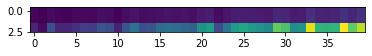

In [23]:
plt.imshow(C2pqab[0,:,:])
print(C2pqab.shape)

# Constructing Matrix: C3 - compute matrix

In [24]:
#define a lasrger scan grid
Ls=fit_range[1]
#rememberig that: r_cent,mu_cent=get_r_mu_from_target(pos_c,Xg[:,Mask>0],ijk[:,Mask>0])

ic,jc,kc = int(Ncells/2),int(Ncells/2),int(Ncells/2)

ijk_c = np.array([ic,jc,kc])

Index_c = GetIndex(ic,jc,kc,Ncells)
pos_c = Xg[:,Index_c]

#note here Mask>0 to speed up calculation knowing there is no mask inside the box
#remove mask otherwise
r_cent,mu_cent = get_r_mu_from_target(pos_c,Xg[:,Mask>0],ijk[:,Mask>0]) 

mask_scan_2r = (r_cent < fit_range[1]*2.) & (r_cent >=fit_range[0])

r_scan_2r = r_cent[mask_scan_2r]
mu_scan_2r = mu_cent[mask_scan_2r]

ijk_scan_2r = (ijk[:,Mask>0])[:,mask_scan_2r]

del r_cent, mu_cent


Ncells_scan_2r = len(mu_scan_2r)
print(Ncells_scan_2r)

84434


<ipython-input-4-e034b5e8a6c2>:7: RuntimeWarning: invalid value encountered in true_divide
  Mu = np.sum(Mid_point*sep_vect,axis=0)/Dist/np.linalg.norm(Mid_point,axis=0)


In [25]:
print(fit_range[1]*2.,Lint/2)

300.0 549.9999907231424


In [26]:
Legendre_l_scan_2r=np.zeros((3,Ncells_scan_2r))
Legendre_l_scan_2r[0], Legendre_l_scan_2r[1], Legendre_l_scan_2r[2] = l0(mu_scan_2r), l2(mu_scan_2r),l3(mu_scan_2r)

In [27]:
xi_mu_r_scan_2r = xi_mu_r(mu_scan_2r,r_scan_2r).real


In [28]:
#considerations for a non-periodic BOX and no mask or weights
#all cells in a sphere of radius Lint/2. - fit_range[1]  from the box center are full
xc = np.mean(Xg_Mask,axis=1)
Dist_center=np.linalg.norm(Xg_Mask-xc[:,None],axis=0)

maks_full_2r = Dist_center <= (Lint/2. - fit_range[1]*2)
NFull_2r=len(Dist_center[maks_full_2r>0])
ijk_empty_2r = ijk_Mask[:,maks_full_2r<0]
NEmpty_2r = Ncells_Mask- NFull_2r

print('frac full', NFull_2r/Ncells_Mask)

frac full 0.04772682934404606


In [29]:
#exagerate and apply cube symmetry for speed up
mask_empty_oct_2r = (Dist_center > (Lint/2. - fit_range[1]*2)) & (Xg_Mask[0,:] <= xc[0]) \
                & (Xg_Mask[1,:] <= xc[1]) & (Xg_Mask[2,:] <= xc[2])
ijk_empty_oct_2r = ijk_Mask[:,mask_empty_oct_2r>0]
NEmpty_oct_2r = len(ijk_empty_oct_2r[0,:])

#count occurrences
Index_mask=np.ones(Ncells_Mask)
Nsub_2r=np.zeros(Ncells_Mask)

for rx in range (0,2):
    for ry in range (0,2):
        for rz in range (0,2):
            mask_i = (Dist_center > (Lint/2. - fit_range[1]*2)) & (Xg_Mask[0,:]*(-1)**rx <= xc[0]*(-1)**rx) \
                & (Xg_Mask[1,:]*(-1)**ry <= xc[1]*(-1)**ry) & (Xg_Mask[2,:]*(-1)**rz <= xc[2]*(-1)**rz)
            Nsub_2r[mask_i] += Index_mask[mask_i]

Nsub_2r[Nsub_2r==0]=1
Nsub_2r=(Nsub_2r/Nsub_2r)**(-1)*8


In [30]:
#Nsub_2r: array of integers, is symmetry was applies, every cell must be multiplied by Nsub
#ijk: 3,N, array of i,j,k of all cells
#ijk_sub: 3,N, array of i,j,k inex of each target cell
#ijk_scan: 3,N, array of i,j,k inex of scan grid
#ijk_scan_2r: 3,N, array of i,j,k inex of secondary scan grid (double size)
#ijk_c: indexes of central cell use to compute the scan grid
#xi_ij_pq_scan: values of xi*Lp*Lq evaluated a t grid_scan points
#Nfull_2r: number of full cells (no symmetry)
#sum_pq_a : contribution of one full cell to c2 
#r_grid: possible r values on the grid
#mu_grid: possible mu values on the grid
#rbins_scan: rray of integers corresponding to bin number of covariance binning of distances
#Nrbins: number of r bins in covariance
@njit(parallel=True)
def C3_pq_a(Run,Nsub_2r, ijk, ijk_sub_2r, ijk_scan, ijk_scan_2r, ijk_c, Nfull_2r, xi_ij_pq_scan, sum_pq_a, rbins_scan, Nrbins):
    
    #compute contribution to full cells
    C3pqab=np.zeros((3,3,Nrbins,Nrbins), dtype=np.float64)
    #C3pqab += sum_pq_a*Nfull
    
    if Run == False: Nc=1
    else: Nc = len(ijk_sub_2r[0])
    
    for p in range(0, 3):
        for q in range(p, 3):
            local_hists = np.zeros((Nc, Nrbins), dtype=np.float64)
            
            for i3D in prange(0, Nc):
                ijk_t = ijk_sub_2r[:, i3D]
               
                Delta = (ijk_t - ijk_c)
                Index3D_scan_new = ijk_scan[0] + Delta[0] + (ijk_scan[1] + Delta[1]) * Ncells + (ijk_scan[1] + Delta[1]) * Ncells**2
                
                wij = Mask[Index3D_scan_new.astype(np.int32)]
                Index3Dj = Index3D_scan_new[wij>0]
                
                if Run == False: Nj=1
                else: Nj = len(wij[wij>0])

                for j in prange(0,Nj):
                    j3D= int(Index3Dj[j])
                    ijk_t = ijk[:,j3D]
                    Delta = (ijk_t - ijk_c)
                   
                    Index3D_scan_new = ijk_scan_2r[0] + Delta[0] + (ijk_scan_2r[1] + Delta[1]) * Ncells + (ijk_scan_2r[1] + Delta[1]) * Ncells**2
                    wjk = Mask[Index3D_scan_new.astype(np.int32)]
                    
                
    return C3pqab
            
#precompilation:
test = C3_pq_a(False, Nsub_2r, ijk, ijk_empty_oct_2r, ijk_scan, ijk_scan_2r, ijk_c, NFull_2r, xi_ij_pq_scan, sum_pq_a, rbins_scan, Nrbins)
         

In [ ]:
t0=time.time()
test = C3_pq_a(True, Nsub_2r, ijk, ijk_empty_oct_2r, ijk_scan, ijk_scan_2r, ijk_c, NFull_2r, xi_ij_pq_scan, sum_pq_a, rbins_scan, Nrbins)
print(time.time()-t0)        
    
    